# Graph evaluation report
- Academic Year: 2019/20
- Faculty of Computing - Artificial Intelligence - Semester 2
- Full name and student id: Kacper Trębacz 145453
- Subject: Algorithms and Data Structures


This exercise consinst of two parts:
- evaluation different graph representations in terms of peformance when searching for an existance of an edge between 2 vertices
- determining best representation for topoligical order sorting and evaluate the time needed to perform it

In [1]:
from random import randint,sample, randrange
import sys
import matplotlib.pyplot as plt
import numpy as np
import time 
import math
import random
import string
import copy
import pandas as pd
import json
import os
import multiprocessing as mp
import psutil 
sys.setrecursionlimit(10**9)
plt.rcParams['figure.figsize'] = (10.0, 6.0)

## Constants declaration

In [2]:

ADJACENCY_MATRIX = "Adjacency Matrix"
INCIDENCE_MATRIX = "Incidence Matrix"
EDGE_LIST = "Edge List"
LIST_OF_INCIDENTS = "List of Incidents"
TIMEOUT = 30
COPIES = 10

In [3]:
def edges_count(n,saturation):
    return int(n*(n-1)*saturation/2)

In [4]:
edge_saturations = [0.2, 0.3, 0.4, 0.6, 0.8, 0.95]

# Part 1

Firstly, we generate graphs with saturation factor 0.6 and save them to text files. There are 21 graphs of size from 2 to 2002 and 21 graphs of size from 2 to 202

In [5]:
def generate_connected_graph(n,saturation):
    array = np.zeros((n,n), dtype=bool)
    n_edges = edges_count(n,saturation)
    connected_edges = [randrange(0,n)]
    not_connected_edges = [i for i in range(n) if i not in connected_edges]
    random.shuffle(not_connected_edges)
    for i in range(n-1):
        not_connected = not_connected_edges.pop()
        connected = random.choice(connected_edges)
        array[not_connected][connected]=True
        array[connected][not_connected]=True
        connected_edges.append(not_connected)
    for i in range(n_edges-n+1):
        x,y = randrange(n), randrange(n)
        while x==y or array[x][y]:
            x,y = randrange(n), randrange(n)
        array[x][y] = True
        array[y][x] = True
    return array

def generate_eulerian_and_write_to_file(min,max,jump,saturations):
    os.makedirs("data/eulerian", exist_ok= True)
    max_tries = 1000000
    copies = 10
    for sat in saturations:
        for i in range(min,max,jump):
            copy=0
            tries = 0
            was_found = False
            while(copy<copies and (was_found or tries <max_tries)):
                graph = generate_connected_graph(i,sat)
                if is_eulerian_for_matrix_rep(graph,i):
                    print("eulerian")
                    was_found = True
                    os.makedirs("data/eulerian/"+str(sat), exist_ok= True)
                    np.savetxt("data/eulerian/"+str(sat)+"/"+str(i)+"_"+str(copy)+".txt", graph, fmt="%5i")
                    copy+=1
                tries+=1
        print(tries)


def generate_radnom_connected_and_write_to_file(min,max,jump,saturations):
    copies = 10
    for sat in saturations:
        print(sat)
        for i in range(min,max,jump):
            copy=0
            os.makedirs("data/eulerian/"+str(sat)+"/"+str(i), exist_ok= True)
            while(copy<COPIES):
                graph = generate_connected_graph(i,sat)
                np.savetxt("data/eulerian/"+str(sat)+"/"+str(i)+"/"+str(copy)+".txt", graph, fmt="%5i")
                copy+=1
    # os.makedirs("data", exist_ok= True)
    # np.savetxt("data/"+str(n)+".txt", array, fmt="%5i")

In [6]:
# generate_radnom_connected_and_write_to_file(11,29,1,edge_saturations)

In [7]:
# generate_radnom_connected_and_write_to_file(10,21,1,edge_saturations)

# Graph representations delaration

Here we delacre functions which convert graphs from text files to a given representation. We also define functions for each reporesentation that check if a given edge exists in graph.

### Adjacency Matrix

In [8]:
def convert_to_adjacency_matrix(n,array):
    return array

def find_edge_adjacency_matrix(array,v1,v2):
    return array[v1][v2]

### List of Incidents

In [9]:
def convert_to_list_of_incidents(n,array):
    incidents_list = []
    for i in range(n):
        incidents = []
        for j in range(n):
            if i !=j and array[i][j] == 1:
                incidents.append(j)
        incidents_list.append(incidents)
    return incidents_list

def find_edge_list_of_incidents(array, v1, v2):
    return v2 in array[v1]

Here we declare dictionaries that would let us perform tests easier

In [10]:
def backtracking_hamiltonian(graph, n_vert, path, depth,startTime):
    if time.time()-startTime >= TIMEOUT:
            print("timeout")
            raise TimeoutError("timeout :(")
    if depth == n_vert:
        return graph[path[depth-1]][path[0]]
    for v in range(0,n_vert):
        if (v not in path) and graph[path[depth-1]][v]:
            path.append(v)
            if backtracking_hamiltonian(graph,n_vert,path,depth+1,startTime):
                return path
            path.pop()
    return False

def backtracking_hamiltonian_adjacency(graph, n_vert, path, depth,startTime):
    if time.time()-startTime >= TIMEOUT:
            print("timeout")
            raise TimeoutError("timeout :(")
    if depth == n_vert:
        return path[0] in graph[path[depth-1]]
    for v in graph[path[depth-1]]:
        if (v not in path):
            path.append(v)
            if backtracking_hamiltonian_adjacency(graph,n_vert,path,depth+1,startTime):
                return path
            path.pop()
    return False

def measure_single_hamiltonian(graph,n):
        try:
            adj_list = convert_to_list_of_incidents(n,graph)
            startTime = time.time()
            backtracking_hamiltonian_adjacency(adj_list,n,[0],1,startTime)
            return time.time()-startTime
        except TimeoutError:
                return TIMEOUT
def measure_time_hamiltonian(graph,n):
    pool = mp.Pool(psutil.cpu_count(logical = False))
    times = pool.starmap(measure_single_hamiltonian,[(graph,n) for i in range(10)])
    pool.terminate()
    return (sum(times)/n)
def read_graph(saturation,n,copy):
    return np.loadtxt("data/eulerian/"+str(saturation)+"/"+str(n)+"/"+str(copy)+".txt", dtype=bool)

def measure_times_hamiltonian(saturation,n):
    print("N: "+str(n))
    pool = mp.Pool(psutil.cpu_count(logical = False))
    times = pool.starmap(measure_single_hamiltonian,[(read_graph(saturation,n,copy),n) for copy in range(COPIES)])
    pool.terminate()
    return sum(times)/COPIES

In [11]:
def plot_plot(X,Ys,labels,title):
    for i in range(len(Ys)):
        plt.plot(X,Ys[i],label=str(labels[i]))
    plt.legend()
    plt.xlabel('Number of Elements')
    plt.ylabel('Time (s)')
    plt.title(title)
    plt.show()
    plt.close()

def perform_test_single_entry(entry, X):
    print("Saturation: "+str(entry))
    return [measure_times_hamiltonian(entry,n) for n in X]

def perform_tests(entries,minimum=11,maximum=22,jump=1):
    X = [i for i in range(minimum,maximum, jump)]
    Ys = [perform_test_single_entry(entry,X) for entry in entries]
    plot_plot(X, Ys, entries, "Hamiltonian cycle search time")
    plt.yscale("log")
    plot_plot(X, Ys, entries, "Hamiltonian cycle search time log")

In [12]:
# perform_tests(edge_saturations,10,29,1)

In [13]:
def is_eulerian_for_matrix_rep(array,n):
    check = np.ones(n)
    for i in range(n):
        if np.dot(array[i],check)%2 == 1:
            return False
    return True

In [26]:
def eulerian_backtracking(graph, n_vert,n_edges, path, depth):
    if depth == n_edges:
        final_edge_exists = path[0] in graph[path[depth-1]]
        if final_edge_exists:
            path.append(path[0])
        return final_edge_exists
    for v in graph[path[depth-1]]:
        graph[path[depth-1]].remove(v)
        graph[v].remove(path[depth-1])
        path.append(v)
        if eulerian_backtracking(graph, n_vert, n_edges, path, depth+1):
            return path
        path.pop()
        graph[path[depth-1]].append(v)
        graph[v].append(path[depth-1])
    return False



def find_eulerian_cycle(graph,n,m):
    for vlist in graph:
        if len(vlist)%2==1:
            return False
    print("wow")
    return eulerian_backtracking(graph,n,m,[0],1)
    

In [36]:
def measure_eulerian_single(graph,n,m):
    adj_list = convert_to_list_of_incidents(n,graph)
    startTime = time.time()
    find_eulerian_cycle(adj_list,n,m)
    return time.time()-startTime

def measure_times_eulerian(saturation,n):
    times = [measure_eulerian_single(read_graph(saturation,n,copy),n,edges_count(n,saturation)) for copy in range(COPIES)]
    return sum(times)/COPIES

In [37]:
def perform_test_single_entry_eulerian(entry, X):
    print("Saturation: "+str(entry))
    return [measure_times_eulerian(entry,n) for n in X]

def perform_tests_eulerian(entries,minimum=11,maximum=22,jump=1):
    X = [i for i in range(minimum,maximum, jump)]
    Ys = [perform_test_single_entry_eulerian(entry,X) for entry in entries]
    plot_plot(X, Ys, entries, "Eulerian cycle search time")

Saturation: 0.2
Saturation: 0.3
Saturation: 0.4
Saturation: 0.6
Saturation: 0.8
Saturation: 0.95


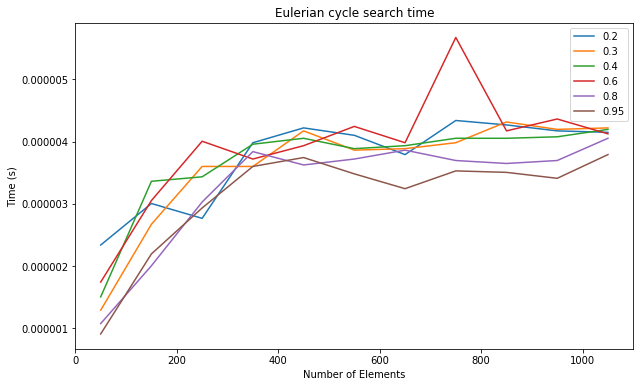

In [38]:
perform_tests_eulerian(edge_saturations,50,1051,100)

In [1]:
# graph = np.array(
#     [[0,1,0,1,0,0],#0
#     [1,0,1,0,1,1],#1
#     [0,1,0,1,0,0],#2
#     [1,0,1,0,1,1],#3
#     [0,1,0,1,0,0],
#     [0,1,0,1,0,0]], dtype=bool)
# print(find_eulerian_cycle(graph,6,8))

In [31]:
generate_radnom_connected_and_write_to_file(50,1051,100,edge_saturations)

0.2
0.3
0.4
0.6
0.8
0.95
